In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# I have experienced stability issues with float32.
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import neurax as nx
from neurax.channels import HHChannel
from neurax.synapses import GlutamateSynapse

### Setup

In [4]:
# Number of segments per branch.
nseg_per_branch = 8

# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

In [5]:
time_vec = jnp.arange(0.0, t_max+dt, dt)

### Define compartment and branch

In [6]:
comp = nx.Compartment([HHChannel()]).initialize()
branch = nx.Branch([comp for _ in range(nseg_per_branch)]).initialize()

### Define cell

Below, we define the morphology. Each element of `parents` corresponds to one branch. A `-1` entry means that this branch does not have a parent. Alternatively, you could also load cells from SWC with 

```parents, lengths, endpoint_rads, start_rad = nx.utils.read_swc(fname, max_branch_len=300.0)```.

You can plot the SWC file with `nx.utils.plot_swc(fname, max_branch_len=300.0)`.

In [18]:
num_branches = 15
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])
assert len(parents) == num_branches

In [19]:
cell = nx.Cell([branch for _ in range(num_branches)], parents=parents).initialize()

Cells can be visualized as follows:

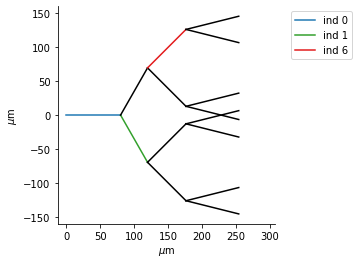

In [27]:
_ = nx.utils.plot_morph(cell, figsize=(4, 4), cols="k", highlight_branch_inds=[0, 1, 6])

### Define connectivity

In this case, two layers fully connected.

In [10]:
num_cells = 16

In [22]:
conn_builder = nx.ConnectivityBuilder([cell.total_nbranches for _ in range(num_cells)])

_ = np.random.seed(0)  # location of post synapse is random.
connectivities = [
    nx.Connectivity(
        GlutamateSynapse(),
        [
            *conn_builder.fc(np.arange(0, 5), np.arange(5, 15)),
            *conn_builder.fc(np.arange(5, 15), np.arange(15, 16)),
        ]
    ),
]

In [23]:
network = nx.Network([cell for _ in range(num_cells)], connectivities).initialize()

### Define stimuli and recordings

In [46]:
recs = [nx.Recording(cell_ind, 1, 0.0) for cell_ind in range(num_cells)]
stims = [
    nx.Stimulus(stim_ind, 1, 0.0, current=nx.step_current(i_delay, i_dur, i_amp, time_vec)) for stim_ind in range(5)
]

### Solve ODE

In [51]:
%%time
s = nx.integrate(network, stimuli=stims, recordings=recs, delta_t=dt)

### Visualize traces

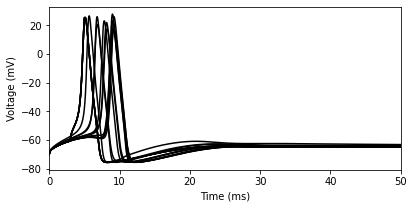

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
for i in range(len(recs)):
    _ = ax.plot(time_vec, s[i][:-1], c="k")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (mV)")
plt.show()